In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import make_swiss_roll
# mnist 
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from lamp import Pinv_ilamp
from NNinv import NNinv_torch
from rbf_inv import RBFinv
from multilateration import MDSinv
from gradient_map import get_gradient_map

### Generate some data

In [2]:
# X, y = make_swiss_roll(n_samples=2000, noise=0.2, random_state=0, hole=False)

# ## scale the data to [0,1] is required for the NNinv
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

# ## plot the original data
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap=plt.cm.jet)

## MNIST
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.astype('float32')/255.0
y = y.astype('int64')


X, _, y, _ = train_test_split(X, y, train_size=10000, random_state=420) ## you may need to use all the data 

## select only 0 and 7 || or try 1 and 7
mask = (y == 0) | (y == 7)
X = np.array(X[mask])
y = np.array(y[mask])
print(X.shape, y.shape)


(2051, 784) (2051,)


### Build  $P$ and $P^{-1}$

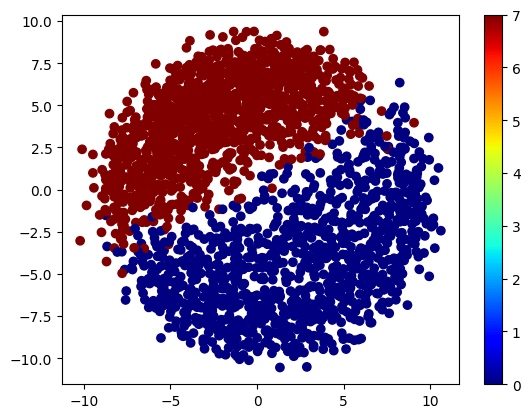

In [3]:
## P, using MDS
X2d = MDS(n_components=2, random_state=42, n_jobs=-1).fit_transform(X)

plt.scatter(X2d[:,0], X2d[:,1], c=y, cmap=plt.cm.jet)
# cbar
plt.colorbar()

In [4]:
## Pinv with ilamp
ilamp = Pinv_ilamp(k=6)
ilamp.fit(X2d, X)

## Pinv with NNinv
nninv = NNinv_torch(dims=[2048, 2048, 2048, 2048],) ## this structure is according the original paper, but it seems too large for most of the datasets we teset (like any 3D dataset, or the MNIST). But it works
nninv.fit(X2d, X, epochs=100)

## Pinv with RBF
rbf = RBFinv()
rbf.fit(X2d, X)

## MDSinv
mdsinv = MDSinv()
mdsinv.fit(X2d, X)

device:  cuda:0
Epoch 1/100, Loss: 0.09411865
Epoch 2/100, Loss: 0.05734465
Epoch 3/100, Loss: 0.05258811
Epoch 4/100, Loss: 0.05148743
Epoch 5/100, Loss: 0.05095045
Epoch 6/100, Loss: 0.05056151
Epoch 7/100, Loss: 0.05028699
Epoch 8/100, Loss: 0.04991870
Epoch 9/100, Loss: 0.04966837
Epoch 10/100, Loss: 0.04906634
Epoch 11/100, Loss: 0.04796795
Epoch 12/100, Loss: 0.04592982
Epoch 13/100, Loss: 0.04560017
Epoch 14/100, Loss: 0.04338490
Epoch 15/100, Loss: 0.04246948
Epoch 16/100, Loss: 0.04447474
Epoch 17/100, Loss: 0.04218403
Epoch 18/100, Loss: 0.04170808
Epoch 19/100, Loss: 0.04182536
Epoch 20/100, Loss: 0.04145341
Epoch 21/100, Loss: 0.04081553
Epoch 22/100, Loss: 0.04178069
Epoch 23/100, Loss: 0.04027256
Epoch 24/100, Loss: 0.04069992
Epoch 25/100, Loss: 0.04019546
Epoch 26/100, Loss: 0.04042131
Epoch 27/100, Loss: 0.03975499
Epoch 28/100, Loss: 0.04131504
Epoch 29/100, Loss: 0.03997936
Epoch 30/100, Loss: 0.04031848
Epoch 31/100, Loss: 0.03960494
Epoch 32/100, Loss: 0.03984361
E

### Inverse proejction some 2D points

In [5]:
## sample some points in the 2D space

xmin, xmax = X2d[:,0].min(), X2d[:,0].max()
ymin, ymax = X2d[:,1].min(), X2d[:,1].max()

x_ = np.linspace(xmin, xmax, 10)
y_ = np.linspace(ymin, ymax, 10)

xx, yy = np.meshgrid(x_, y_)
samples = np.c_[xx.ravel(), yy.ravel()]

## Pinv with ilamp
samples_ilamp = ilamp.transform(samples)

## Pinv with NNinv
samples_nninv = nninv.transform(samples)

## Pinv with RBF
samples_rbf = rbf.transform(samples)

## MDSinv
samples_mdsinv = mdsinv.transform(samples)

100%|██████████| 100/100 [00:00<00:00, 162004.79it/s]


100
(784,)
(784,)


In [6]:
# mdsinv_closet = MDSinv(point_selection='closest')
# mdsinv_closet.fit(X2d, X)
# ## MDSinv
# samples_mdsinv_close = mdsinv.transform(samples)

Text(0.5, 0.98, 'RBF')

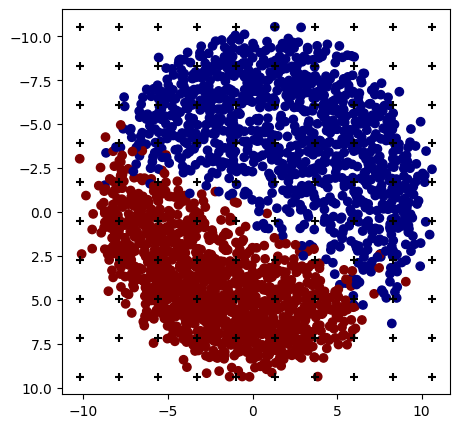

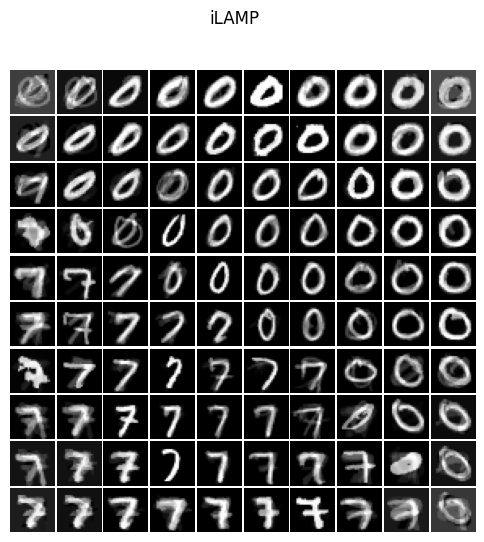

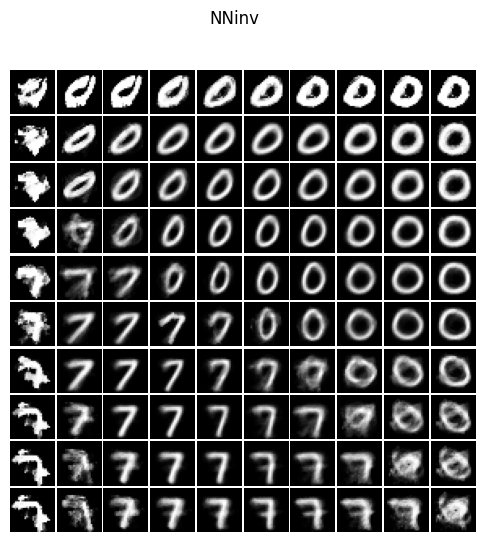

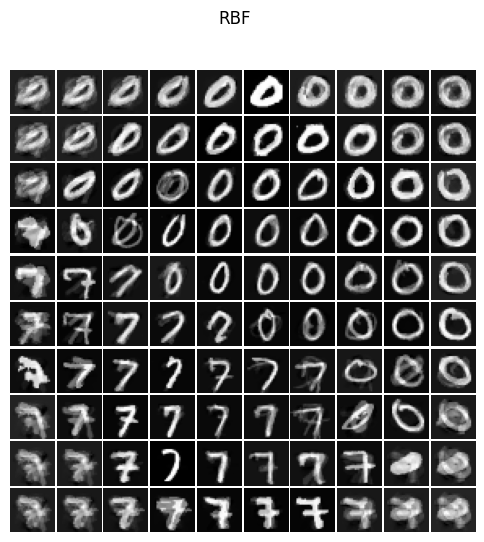

In [7]:
## plot the results
fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.scatter(X2d[:,0], X2d[:,1], c=y, cmap=plt.cm.jet)
ax.scatter(samples[:,0], samples[:,1], c='black', marker='+')
ax.invert_yaxis()

## results of ilamp
fig1, axes = plt.subplots(10, 10, figsize=(6,6))
fig1.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_ilamp[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig1.suptitle('iLAMP')

## results of NNinv
fig2, axes = plt.subplots(10, 10, figsize=(6,6))
fig2.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_nninv[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig2.suptitle('NNinv', )

## results of RBF
fig3, axes = plt.subplots(10, 10, figsize=(6,6))
fig3.subplots_adjust(hspace=0.05, wspace=0.05)
for i in range(100):
    ax = axes[i//10, i%10]
    ax.imshow(samples_rbf[i].reshape(28,28), cmap='gray')
    ax.axis('off')
fig3.suptitle('RBF')

# ## results of MDSinv
# fig4, axes = plt.subplots(10, 10, figsize=(6,6))
# fig4.subplots_adjust(hspace=0.05, wspace=0.05)
# for i in range(100):
#     ax = axes[i//10, i%10]
#     ax.imshow(samples_mdsinv[i].reshape(28,28), cmap='gray')
#     ax.axis('off')
# fig4.suptitle('MDSinv')

# ## results of MDSinv
# fig5, axes = plt.subplots(10, 10, figsize=(6,6))
# fig5.subplots_adjust(hspace=0.05, wspace=0.05)
# for i in range(100):
#     ax = axes[i//10, i%10]
#     ax.imshow(samples_mdsinv_close[i].reshape(28,28), cmap='gray')
#     ax.axis('off')

# fig5.suptitle('MDSinv_closest')

### compute gradient maps

In [8]:
inv_methods = {
    'iLAMP': ilamp,
    'NNInv': nninv,
    'RBF': rbf,
    # 'MDSinv': mdsinv,
    # 'mdsinv_closest': mdsinv_closet
}

map_grid = 100

grad_map_dict = {}
nD_grids_dict = {}
global_min = 1e10
global_max = -1e10
for name, inv in inv_methods.items():
    grad_map, nD_grid = get_gradient_map(inv, X2d, map_grid)
    grad_map_dict[name] = grad_map.reshape(map_grid, map_grid)
    print(min(grad_map), max(grad_map))
    global_min = min(global_min, min(grad_map))
    global_max = max(global_max, max(grad_map))
    nD_grids_dict[name] = nD_grid

100%|██████████| 10404/10404 [00:00<00:00, 31066.77it/s]


1.3032967426294326 29.342997994897544
0.97098535 20.107681
1.5913300855857762 30.058805378406472


0.011424417139066702 0.9753915080991445
0.0 0.6578938
0.02132661478415301 1.0


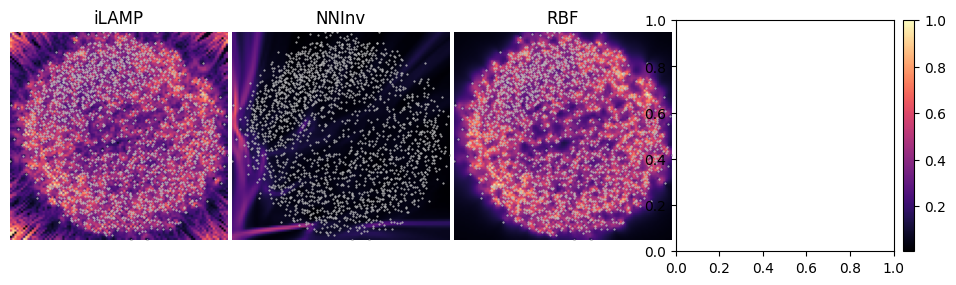

In [9]:

fig, axes = plt.subplots(1, 4, figsize=(12,3))

# white space
fig.subplots_adjust(wspace=0.02)

for i, (name, grad_map) in enumerate(grad_map_dict.items()):
    ax = axes[i]
    scaled_grad_map = (grad_map - global_min) / (global_max - global_min)
    print(scaled_grad_map.min(), scaled_grad_map.max())

    # flipp the x axis
    scaled_grad_map = np.flip(scaled_grad_map, axis=0)

    ### scaled individually
    # im = ax.imshow(scaled_grad_map, cmap='magma') ## this will rescale the data to [0,1]
    
    ## scaled globally
    image = cm.magma(scaled_grad_map)
    im = ax.imshow(image, cmap='magma', extent=[xmin, xmax, ymin, ymax])
    ax.set_title(name)
    ax.axis('off')
    ax.scatter(X2d[:,0], X2d[:,1], c='#BBBBBB', s=1, marker='.')

fig.colorbar(im,  ax=axes, orientation='vertical', fraction=0.04, pad=0.01, )


0.011424417139066702 0.9753915080991445
0.0 0.6578938
0.02132661478415301 1.0


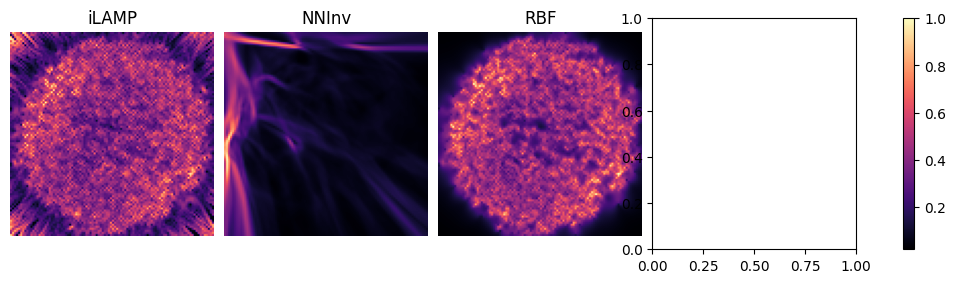

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(12,3))

# white space
fig.subplots_adjust(wspace=0.05)

for i, (name, grad_map) in enumerate(grad_map_dict.items()):
    ax = axes[i]
    scaled_grad_map = (grad_map - global_min) / (global_max - global_min)
    print(scaled_grad_map.min(), scaled_grad_map.max())

    ### scaled individually
    im = ax.imshow(scaled_grad_map, cmap='magma') ## this will rescale the data to [0,1]

    ## scaled globally
    # image = cm.magma(scaled_grad_map)
    # im = ax.imshow(image, cmap='magma')
    ax.set_title(name)
    ax.axis('off')



fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.04, )